# CoT Promting
Исполняйте ячейки этого notebook-а последовательно, по порядку.

# Сначала загрузим petals, датасет GSM8K, и импортируем необходимые модули.

:


In [ ]:
# необходимо, что оператировано сохранять результаты вычислений. Для проверяющего это не нужно.
# drive.mount('/content/drive',  force_remount=True)


Mounted at /content/drive


In [1]:
!git clone https://github.com/Artemmakanov/TLab2023_CoT_promting
%cd /content/TLab2023_CoT_promting


Cloning into 'TLab2023_CoT_promting'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 54 (delta 18), reused 46 (delta 10), pack-reused 0
Unpacking objects: 100% (54/54), 588.71 KiB | 673.00 KiB/s, done.
/content/TLab2023_CoT_promting


In [2]:
!pip install -q petals

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!git clone https://github.com/openai/grade-school-math


Cloning into 'grade-school-math'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 36 (delta 10), reused 7 (delta 7), pack-reused 16
Unpacking objects: 100% (36/36), 3.13 MiB | 2.27 MiB/s, done.


In [4]:
from processer import DatasetProcesser, OutputProcesser
from utils import compute_accuracy, compute_delta
from model import Model
import random
import json
import os
import numpy as np

# Подгружаем датасет
Перемешиваем тренировочные и тестовый датасет, и удаляем из ответов конструкции типа <<5+5=10>>

In [5]:
dataset_processer = DatasetProcesser()
output_processer = OutputProcesser(mode="last_num")

dataset_processer.read_dataset_jsonl("grade-school-math/grade_school_math/data/test.jsonl")
dataset_processer.read_dataset_jsonl("grade-school-math/grade_school_math/data/train.jsonl")

dataset_processer.shuffle_dataset()
dataset_processer.remove_symbols()

# Эксперименты с моделью BLOOM-7b при стандартном режиме CoT Prompting;
Пробегаемся по нескольким вариантам генерации, и повторяем эксперимент 2 раза, для того, чтобы избевиться от элемента случайности. Берем только первые 100 примеров из датасета.

In [6]:
NUM_OF_LAUNCHES = 100

kwargs = {"model_size": "mini", "is_bonus": False, "gpu": True}

for gen_regime in ["sample", "top-k", "top-p"]:

    for seed in range(1,3):
        
        kwargs["gen_regime"] = gen_regime
        kwargs["seed"] = seed

        model = Model(**kwargs )

        results = []
        for i in range(NUM_OF_LAUNCHES):
            
            example = dataset_processer.dataset[i]
            prompt_index = random.sample(list(range(8)), 1)[0]
            prompt = model.prompts[prompt_index]
            prompt_plus_question = model.prompt_plus_quesion(prompt, example["question"] )
            outputs = model.produce_answer(prompt_plus_question)
            result = {}
            result["indx_example"] = i
            result["prompt_index"] = prompt_index
            result["outputs"] = outputs
            
            print(i, outputs, output_processer.parse_num(outputs))

            results.append(result)
            # Для проверяющего это не нужно.
            # сохраняем результаты
            # path_for_results = "results_{0}_{1}_{2}_seed_{3}.jsonl".format(kwargs["model_size"], "standard", gen_regime, seed)
            # with open(path_for_results, 'w') as f:
            #     json.dump(results, f)
            # необходим для оперативного сохранения результатов в гугл диск
            # os.system("cp {} /content/drive/MyDrive".format(path_for_results))




Downloading:   0%|          | 0.00/322 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/786 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

0  Each balloon holds 10 liters of air. So if he bought 500-balloon safes, he could fill them in 50-years. If he buys 100-liter tanks, he can fill them in 40 years. If 1-5 couples of them buy 10-15 tanks apiece, after one year they can fill 100-balloon safes. When do they fill all the balloons?
 100.0
1  He has 3 + 4 = 7 Butterfingers.
 7.0
2  The first ratio is 32 quarters : 95 dimes : 120 nickels : 750 pennies = 0.90 < 1.75. Most people, though, use the following key: 32 quarters : 95 dimes : 120 nickels = 1/2 percent. There is a quarter in every 10 dimes and exactly 1 dollar in every 50 nickels. LX10980</s> 10980.0


KeyboardInterrupt: ignored

# Эксперименты с моделью BLOOM-7b при ансамблированном режиме CoT Prompting;
Как и раньше, проходим по нескольким вариантам генерации, и повторяем эксперимент 2 раза, для того, чтобы избавиться от элемента стохастичности. Берем только первые 30 примеров из датасета, те же самые.

In [7]:
NUM_OF_LAUNCHES = 30
NUM_REASONING_PATH = 5

kwargs = {"model_size": "mini", "is_bonus": False, "gpu": True}

for gen_regime in ["sample", "top-k", "top-p"]:
    for seed in range(1,3):

        kwargs["gen_regime"] = gen_regime
        kwargs["seed"] = seed


        model = Model(**kwargs )

        results = []
        for i in range(NUM_OF_LAUNCHES):
            example = dataset_processer.dataset[i]
            prompt_index = random.sample(list(range(8)), 1)[0]
            prompt = model.prompts[prompt_index]
            prompt_plus_question = model.prompt_plus_quesion(prompt, example["question"] )
            
            

            result = {}
            result["indx_example"] = i
            result["prompt_index"] = prompt_index

            outputs_lst = []
            
            # генерируем ответ столько, сколько reasoning paths num
            for j in range(NUM_REASONING_PATH):
                outputs = model.produce_answer(prompt_plus_question)
                
                print(i, j, outputs, output_processer.parse_num(outputs))
                outputs_lst.append(outputs)

            result["outputs"] = outputs_lst
            results.append(result)
            # Для проверяющего это не нужно.
            # сохраняем результаты
            # path_for_results = "results_{0}_{1}_{2}_seed_{3}.jsonl".format(kwargs["model_size"], "ansamble", gen_regime, seed)
            # with open(path_for_results, 'w') as f:
            #     json.dump(results, f)

            # необходим для оперативного сохранения результатов в гугл диск
            # os.system("cp {} /content/drive/MyDrive".format(path_for_results))


0 0  Each balloon holds 10 liters of air. So if he bought 500-balloon safes, he needed 500 x 10 = 5000 liters of gas to fill the balloons.
 5000.0
0 1  First, John bought 1000 balloons. Each balloon has 10 liters of air. Hence after buying one balloon, the total amount of air is 1000*0.10 = 100 liters. After buying second bolt, the total amount of air is 1000*(0.10) = 10 liters... Ân d after buying 1000 balloons, the total amount of air is 1000*1000*0.01 = 1 million liters.
 1.0
0 2  If you have 1000 balloons, then you have 1000 * 10 = 10000. There is a 500-liter tank which represents 1000 * 500 = 5000 liters. So you need 50 banks of 500-liter tanks to fill all the balloons.
 500.0


KeyboardInterrupt: ignored

# Эксперименты с моделью BLOOM-7b при модифицированном ансамблированном режиме CoT Prompting;
Все также. Стоит заметить, что если все значения, которые дают промпты равны, то в качестве ответа должен рассматриваться тот, что сгененировался с промптом, наиболее семантически близким к вопросу.


In [8]:
NUM_OF_LAUNCHES = 30
NUM_REASONING_PATH = 5

kwargs = {"model_size": "mini", "is_bonus": True, "gpu": True}

for gen_regime in ["sample", "top-k", "top-p"]:
    for seed in range(1,3):

        kwargs["gen_regime"] = gen_regime
        kwargs["seed"] = seed


        model = Model(**kwargs )

        results = []
        for i in range(NUM_OF_LAUNCHES):
            example = dataset_processer.dataset[i]


            # получаем наиоблее семантически близки к впоросу промпты
            idx_prompts = model.select_idx_prompts(example['question'])
            idx_prompts = [int(idx_prompt) for idx_prompt in idx_prompts]
            prompts = [model.prompts[idx] for idx in idx_prompts]

            result = {}
            result["indx_example"] = i
            result["prompts_index"] = idx_prompts
            outputs_lst = []

            for j in range(NUM_REASONING_PATH):

                prompt_plus_question = model.prompt_plus_quesion(prompts[j], example["question"] )
                outputs = model.produce_answer(prompt_plus_question)
                
                result["outputs"] = outputs
                print(i, j, outputs, output_processer.parse_num(outputs))
                outputs_lst.append(outputs)

            result["outputs"] = outputs_lst
            results.append(result)
            # Для проверяющего это не нужно.
            # сохраняем результаты
            # path_for_results = "results_{0}_{1}_{2}_seed_{3}.jsonl".format(kwargs["model_size"], "bonus", gen_regime, seed)
            # with open(path_for_results, 'w') as f:
            #     json.dump(results, f)
                
            # необходим для оперативного сохранения результатов в гугл диск
            # os.system("cp {} /content/drive/MyDrive".format(path_for_results))

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0 0  Each balloon is $10. Solution is 50. So 50/1000 = 4.5.  50 /500 = 0.7
 0.7
0 1  Since each balloon holds 10 liters, his total gross stock is 100,000 liters. If 1-5 couples of # 100-liter tanks are used, then he has 500/1000 = 50% left for his couples. So he need 50/100 = 0.5 'incubation tanks. Now /1000 = 0.01 ratio. There are 100/500 = 1/100 = 1 'aspirating or pumping tank. So he need 1/100/1000, or.1 liters of gas per balloon. So.001 liters of gas are used for each cubic meter of air. (Comparatively, Will Rogers lost only.0001% of his tailgage!)
 0.0001
0 2  One 1000-liter gas tank will fill all 1000 balloons.
 1000.0


KeyboardInterrupt: ignored

# Эксперименты с моделью BLOOM-176b при стандартном режиме CoT Prompting.
Часто с petals нарушается соединение

In [9]:
NUM_OF_LAUNCHES = 15

kwargs = {"model_size": "big", "is_bonus": False, "gpu": True}

for gen_regime in ["sample", "top-k", "top-p"]:

    for seed in range(1,3):
        
        kwargs["gen_regime"] = gen_regime
        kwargs["seed"] = seed

        model = Model(**kwargs )

        results = []
        for i in range(NUM_OF_LAUNCHES):
            
            example = dataset_processer.dataset[i]
            prompt_index = random.sample(list(range(8)), 1)[0]
            prompt = model.prompts[prompt_index]
            prompt_plus_question = model.prompt_plus_quesion(prompt, example["question"] )
            outputs = model.produce_answer(prompt_plus_question)
            result = {}
            result["indx_example"] = i
            result["prompt_index"] = prompt_index
            result["outputs"] = outputs
            
            print(i, outputs, output_processer.parse_num(outputs))

            results.append(result)
            # сохраняем результаты
            # path_for_results = "results_{0}_{1}_{2}_seed_{3}.jsonl".format(kwargs["model_size"], "standard", gen_regime, seed)
            # with open(path_for_results, 'w') as f:
            #     json.dump(results, f)
            # необходим для оперативного сохранения результатов в гугл диск
            # os.system("cp {} /content/drive/MyDrive".format(path_for_results))




Downloading:   0%|          | 0.00/263 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.19G [00:00<?, ?B/s]

Feb 27 17:27:09.835 [INFO] Peer 12D3KooWAp4g4yANgjAN6pZodKYCwqPq7p4jhSCYKaBCYLY3CwQX did not respond, banning it temporarily
Feb 27 17:27:09.837 [WARN] [/usr/local/lib/python3.8/dist-packages/petals/client/inference_session.py.step:311] Caught exception when running inference from block 34 (retry in 0 sec): TimeoutError()
Feb 27 17:27:09.842 [WARN] [/usr/local/lib/python3.8/dist-packages/petals/client/routing/sequence_manager.py.make_sequence:109] Remote SequenceManager is still searching for routes, waiting for it to become ready


KeyboardInterrupt: ignored

# Добавим суффикс "The answer is" в конец ответа, и скормим опять модели

In [10]:
import itertools

In [11]:
kwargs = {"model_size": "mini", "is_bonus": False, "gpu": True,
          "gen_regime": "sample", "seed": 1, "sec_proc": True}

model = Model(**kwargs )

mini_lst = list(itertools.product(["mini"], ["standard", "ansamble", "bonus"], ["sample", "top-k", "top-p"], [1,2]))
big_lst = list(itertools.product(["big"], ["standard"], ["sample", "top-k"], [1,2]))
for model_size, realization,gen_regime, seed in  (mini_lst + big_lst):

    path = 'results/results_{0}_{1}_{2}_seed_{3}.jsonl'.format(model_size, realization,
                                                          gen_regime, seed)
    with open(path, "r") as fh:
        data = json.loads(fh.read())


    for i, example in enumerate(data):
        
        example["sec_proc"] = model.sec_proc(dataset_processer, model_size, realization,
                                              gen_regime, seed, i, example)
        print(example["outputs"], example["sec_proc"])
        # with open(path, 'w') as f:
        #    json.dump(data, f)
        # необходим для оперативного сохранения результатов в гугл диск
        # os.system("cp {} /content/drive/MyDrive".format(path))

 Each balloon holds 10 liters of air. So if he bought 500-balloon safes, he could fill them in 50-savable-liters of gas. It is a 1,000-bayoness-go 1-5 couples of # 100.
  50 * 100 = 5000.

 Mark wants an equal share of Mars and Snickers. For him, that will be 3 each (3+3 = 6). He also needs 3 Butterfingers.  So total for him is 9.
  9.

 75.875.
  $75.875 because the value of quarters is 50, dimes is one, and nickels is 5. The indirect answer is 81.25 because the value of each group is the sum of their individual values.

 Vann the veterinarian has 42 teeth in dogs, 30 teeth in cats and 28 teeth in pigs. He wants to do 5 dogs, 10 cats and 7 pigs. So, he needs to clean 42 - 42 - 28 = 14 teeth in dogs, 30 - 42 - 30 = 4 teeth in cats, and 28 - 42 - 28 = 8 teeth in pigs. The answer is 14 + 4 + 8 = 46 teeth in dogs, 30 + 4 + 7 = 48 teeth in cats, and 28 + 4 + 28 = 49 teeth in pigs.
  1 + 43 + 1 + 1 + 49 + 1 = 101 is because it is the smallest number that is less than 1000.



KeyboardInterrupt: ignored

# Посчитаем точность предсказания вместе с погрешностями
###Для стандартной реализации CoT модели bloom 7b:

In [12]:
acc_lst = [compute_accuracy(dataset_processer, output_processer, "mini", "standard", "sample", seed)["acc"] for seed in range(1,3)]

print("="*80 + "\nAcc: {0}% +- {1}%".format(np.mean(acc_lst) * 100 , compute_delta(acc_lst) * 100))


seed = 1

seed = 2

Question: After complaints from the residents of Tatoosh about the number of cats on the island, the wildlife service carried out a relocation mission that saw the number of cats on the island drastically reduced. On the first relocation mission, 600 cats were relocated from the island to a neighboring island. On the second mission, half of the remaining cats were relocated to a rescue center inland. If the number of cats originally on the island was 1800, how many cats remained on the island after the rescue mission?
Answer:  on the first mission that consisted of 600 cats, there were 1800 - 600 = 900 cats on the island. On the second mission that included 400 cats, there were 900 - 400 = 600…

Num_candidate = 600.0
Num_golden = 600.0
Question: Phoebe eats 1 serving and gives her dog 1 serving of peanut butter for a bedtime snack. Each jar of peanut butter has 15 servings.  How many jars will she need to make sure she and her dog have enough to last for 30 days?
An

In [13]:
acc_lst = [compute_accuracy(dataset_processer, output_processer, "mini", "standard", "top-k", seed)["acc"] for seed in range(1,3)]
print("="*80 + "\nAcc: {0}% +- {1}%".format(np.mean(acc_lst)  * 100 , compute_delta(acc_lst) * 100))

seed = 1

Question: After complaints from the residents of Tatoosh about the number of cats on the island, the wildlife service carried out a relocation mission that saw the number of cats on the island drastically reduced. On the first relocation mission, 600 cats were relocated from the island to a neighboring island. On the second mission, half of the remaining cats were relocated to a rescue center inland. If the number of cats originally on the island was 1800, how many cats remained on the island after the rescue mission?
Answer:  There were 1800 cats on the island, but after the first relocation, there were 1600 and then after the second relocation there were 600. After two relocation, the number of cats on the island decreased by 1400. Since there were 1800 cats in the first place, the number of remaining cats is 1800 - 1400 = 600</s>
Num_candidate = 600.0
Num_golden = 600.0
Question: This weekend's football game matched the Seattle Seahawks with the Denver Broncos. The final s

In [14]:
acc_lst = [compute_accuracy(dataset_processer, output_processer, "mini", "standard", "top-p", seed)["acc"] for seed in range(1,3)]
print("="*80 + "\nAcc: {0}% +- {1}%".format(np.mean(acc_lst) * 100 , compute_delta(acc_lst) * 100))

seed = 1

Question: Renaldo drove 15 kilometers. Ernesto drove 7 kilometers more than one-third of Renaldo's distance. How many kilometers did the 2 men drive in total?
Answer:  Ernesto drove (7+15)/3 = 12.5 kilometers. Therefore, Renaldo drove 12.5 + 15 = 27 kilometers. The answer is 27.

Num_candidate = 27.0
Num_golden = 27.0
Question: Bailey is making a rectangle out of a 100cm length of rope he has. If the longer sides of the rectangle were 28cm long, what is the length of each of the shorter sides?
Answer:  The longer sides of the rectangle are 100 - 28 = 56 cm and the shorter sides are 56 - 28 = 22 cm.

Num_candidate = 22.0
Num_golden = 22.0
Question: Thomas has 25 drawings to display. 14 of the drawings were made using colored pencils. 7 of the drawings were made using blending markers. The rest of the drawings were made with charcoal. How many are charcoal drawings?
Answer:  Thomas has 25 drawings. 14 of the drawings were made using colored pencils. 7 of the drawings were made 

###Для стандартной реализации CoT модели bloom 176b:

In [15]:
acc_lst = [compute_accuracy(dataset_processer, output_processer, "big", "standard", "sample", seed)["acc"] for seed in range(1,3)]
print("="*80 + "\nAcc: {0}% +- {1}%".format(np.mean(acc_lst) * 100 , compute_delta(acc_lst) * 100))

seed = 1

Question: Ten adults went to a ball game with eleven children. Adult tickets are $8 each and the total bill was $124. How many dollars is one child's ticket?
Answer:  The total cost would be $10$ adults times $8$ dollars + $11$ children times $7$ dollars = $ 124$. There were $11$ children who went to the ball game, so we need to figure out how much it cost for one child, $10$ adults times $8$ = $80$ + $11$ children times $7$ = $77$. So $80-76$ = $4$ dollars. So one child's ticket cost $4$ dollars.

Num_candidate = 4.0
Num_golden = 4.0
seed = 2

Question: Jessie invited 4 friends over to play. They made muffins for a snack and Jesse wants to divide them equally between herself and her friends. If they made 20 muffins in total, how many will each person have?
Answer:  The question details 20 muffins, so we can leave 20 as-is. Jessie is one person, so she has 20/4 muffins. 4 is the same as 4 friends, so the friends will have 20/4, too.


Num_candidate = 4.0
Num_golden = 4.0
Acc:

In [16]:
acc_lst = [compute_accuracy(dataset_processer, output_processer, "big", "standard", "top-k", seed)["acc"] for seed in range(1,3)]
print("="*80 + "\nAcc: {0}% +- {1}%".format(np.mean(acc_lst) * 100 , compute_delta(acc_lst) * 100))

seed = 1

seed = 2

Question: Jessie invited 4 friends over to play. They made muffins for a snack and Jesse wants to divide them equally between herself and her friends. If they made 20 muffins in total, how many will each person have?
Answer:  The question does not give us this information. Only that Jesse wants to distribute the muffins equally. If Jessie has 4 friends, then she will have 5 muffins. 20 / 5 = 4. 

Num_candidate = 4.0
Num_golden = 4.0
Acc: 6.25% +- 6.25%


###Для ансамблированного CoT:

In [17]:
exp_len = 30
all_exp_analysis = {}

In [18]:
analysis_lst = [compute_accuracy(dataset_processer, output_processer, "mini", "ansamble", "sample", seed) for seed in range(1,3)]
acc_lst = ([analysis["acc"] for analysis in analysis_lst])
all_exp_analysis["ansamble_sample"] = analysis_lst
print("="*80 + "\nAcc: {:2.2f}% +- {:2.2f}%".format(np.mean(acc_lst)  * 100 , compute_delta(acc_lst) * 100))

seed = 1

seed = 2

Acc: 0.00% +- 0.00%


In [19]:
analysis_lst = [compute_accuracy(dataset_processer, output_processer, "mini", "ansamble", "top-k", seed) for seed in range(1,3)]
acc_lst = ([analysis["acc"] for analysis in analysis_lst])
all_exp_analysis["ansamble_top-k"] = analysis_lst

print("="*80 + "\nAcc: {:2.2f}% +- {:2.2f}%".format(np.mean(acc_lst)  * 100 , compute_delta(acc_lst) * 100))

seed = 1

seed = 2

Question: Every morning, Carla puts 79 apples in her backpack to eat for lunch. Unfortunately, Buffy stole some of Carla's apples on the school bus, and 26 apples fell out of a hole on the bottom. So at lunchtime, Carla only had 8 apples remaining. How many apples did Buffy steal from Carla?
Answer: [' At lunchtime, Buffy had only 8 apples. 8 – 79 = 26. Buffy stole 26 apples. And 26 apples are the apples that fell out from the hole.\n', ' At lunch time, 59 apples left. That was 19 apples that Buffy stole from Carla and 46 that fell out of the hole. So 19 + 46 is 73. 8 - 73 is 19. The answer is 19.\n', ' In morning, she put into backpack, 79 apples. Then, she picked up a bus, then she saw 26 apples fell into a hole. Then they ate apples at lunch. Total amount of apples are 78. So, she stole 8 apples. The answer is 8.\n\n', ' There were 79 apples at the beginning. Buffy stole 26 apples. Then, 8 apples fell out of the hole. So the number of apples remained is 79 - 26 =

In [20]:
analysis_lst = [compute_accuracy(dataset_processer, output_processer, "mini", "ansamble", "top-p", seed) for seed in range(1,3)]
acc_lst = ([analysis["acc"] for analysis in analysis_lst] )
all_exp_analysis["ansamble_top-p"] = analysis_lst
print("="*80 + "\nAcc: {:2.2f}% +- {:2.2f}%".format(np.mean(acc_lst)  * 100 , compute_delta(acc_lst) * 100))

seed = 1

Question: Mark has 12 candy bars in total between Mars bars, Snickers, and Butterfingers.  He has 3 Snickers and 2 Mars bars.  How many Butterfingers does he have?
Answer: [' If he has 3 Snickers and 2 Mars bars, then he is left with 7 candy bars. This is done with this equation.\n', ' Mark has 3 Snickers, 2 Mars bars, and 6 Butterfingers. 12 – (3 + 2) = 7. The answer is 7.\n', ' Mark starts with 12 Mars bars. If he got 3 Snickers and 2 Mars bars, then that is 5 more Mars bars. 12 + 5 = 17. The answer is 17.\n', ' Mark has 12 candy bars. He has 2 Mars bars and 2 Butterfingers. Therefore, the number of Butterfingers is 4.\n', ' Mark starts with 12 candy bars. From the first candy bar, he gets 3 candy bars each of Mars bars and Snickers.  In total, he has 2 candy bars of each type.  He has 3 Snickers and 2 Mars bars, for a total of 4 candy bars.  4 + 12 = 18.\n']
Num_candidate = 7.0
Num_golden = 7.0
Question: Shane prepares sandwiches for the Boy Scouts. He buys 2 packages of s

Попробуем достать ответ, полученный с помощью вторичной обработки

In [21]:
mini_lst = list(itertools.product(["mini"], ["standard", "ansamble"], ["sample", "top-k", "top-p"]))
big_lst = list(itertools.product(["big"], ["standard"], ["sample", "top-k"]))
for model_size, realization, gen_regime in  (mini_lst + big_lst):
    print(model_size, realization, gen_regime)
    acc_lst = [compute_accuracy(dataset_processer, output_processer, model_size, realization, gen_regime, seed, sec_proc=True, log=False)["acc"] for seed in range(1,3)]
    print("\nAcc: {:2.2f}% +- {:2.2f}%".format(np.mean(acc_lst) * 100 , compute_delta(acc_lst) * 100) + "\n" + "="*80 )


mini standard sample

Acc: 2.00% +- 1.00%
mini standard top-k

Acc: 1.50% +- 1.50%
mini standard top-p

Acc: 0.50% +- 0.50%
mini ansamble sample

Acc: 3.33% +- 3.33%
mini ansamble top-k

Acc: 0.00% +- 0.00%
mini ansamble top-p

Acc: 0.00% +- 0.00%
big standard sample

Acc: 3.33% +- 3.33%
big standard top-k

Acc: 6.25% +- 6.25%


###Посчитаем как часто в ответах - кандитатах содержатся хотя бы раз совпадающие ответы?

In [22]:
mn = np.mean([all_exp_analysis[exp_name][i]["cnt_golden_in_candidates"] for i in range(0,2) for exp_name in ["ansamble_sample", "ansamble_top-k", "ansamble_top-p"]])
"Правильный ответ встречается в кандитатах-ответах в {:2.2f}% случаев".format(mn * 100 / exp_len)

'Правильный ответ встречается в кандитатах-ответах в 10.00% случаев'

###Как часто ансамблированный метод работает (т.е. ответы, полученные из всех reasoning paths хотя бы один раз повторяются)

In [23]:
mn = np.mean([all_exp_analysis[exp_name][i]["cnt_ansamble_works"] for i in range(0,2) for exp_name in ["ansamble_sample", "ansamble_top-k", "ansamble_top-p"]])
"Ансамбль работает в {:2.2f}% случаев".format(mn * 100 / exp_len)

'Ансамбль работает в 25.00% случаев'

# Исследуем зависимость правильности ответа от длины A



In [24]:
mini_lst = list(itertools.product(["mini"], ["standard"], ["sample", "top-k", "top-p"],  [1,2]))
big_lst = list(itertools.product(["big"], ["standard"], ["sample", "top-k"], [1,2]))

vector = []

for model_size, realization, gen_regime, seed in  (mini_lst + big_lst):
    vector += compute_accuracy(dataset_processer, output_processer, model_size, realization, gen_regime, seed, log=False, vector=True)["vector"]

    

In [25]:
vector_of_true = [pair[0] for pair in vector if pair[1] == 1]
vector_of_fasle =  [pair[0] for pair in vector if pair[1] == 0]

In [26]:
print("mean of lens of correct answers = {:2.2f}".format(np.mean(vector_of_true)))
print("mean of lens of incorrrect answers = {:2.2f}".format(np.mean(vector_of_fasle)))

mean of lens of correct answers = 41.69
mean of lens of incorrrect answers = 41.15


# Как часто в CoT присутствует конструкция 'answer is'?

In [27]:
mini_lst = list(itertools.product(["mini"], ["standard"], ["sample", "top-k", "top-p"],  [1,2]))
big_lst = list(itertools.product(["big"], ["standard"], ["sample", "top-k"], [1,2]))

prob_lst = []

for model_size, realization, gen_regime, seed in  (mini_lst + big_lst):
    prob_lst.append(compute_accuracy(dataset_processer, output_processer, model_size, realization, gen_regime, seed, log=False, cnt_phrase=True)["cnt_phrase"])



In [28]:
"'Answer is' присутствует в ответе = {:2.2f} %".format(np.mean(prob_lst) * 100)

"'Answer is' присутствует в ответе = 14.31 %"

# Исследуем частоты выбора подсказки на основе семантической близости к вопросу.
В основу модифицированного алгоритма ансамблированного CoT лежит выбор промпта, наиболее бизкого по смыслу к задачке. Интересно, как часто будет выбираться определенный промпт?

In [29]:
from transformers import AutoTokenizer,BertModel
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt


In [30]:
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = BertModel.from_pretrained(checkpoint).cuda()

cos = nn.CosineSimilarity(dim=0, eps=1e-6)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
with open('promts.jsonl', 'r') as f:
    # Use the json dumps method to write the list to disk
    prompts = json.loads(f.read())

In [32]:
hidden_state_layer = 6

df_prompts_idx_lst = []
for i in range(30):
    question_src = dataset_processer.dataset[i]["question"]
    
    inputs_src = tokenizer(question_src, return_tensors="pt")["input_ids"].cuda()

    outputs_src = model(inputs_src, output_hidden_states=True)

    
    question_src_emb = outputs_src.hidden_states[hidden_state_layer][0][0]
    
    prompts_question_embs = []

    for prmopt in prompts:

        inputs = tokenizer(prmopt["question"], return_tensors="pt")["input_ids"].cuda()
        outputs = model(inputs, output_hidden_states=True)
        prompts_question_emb = outputs.hidden_states[hidden_state_layer][0][0]
        prompts_question_embs.append(prompts_question_emb)
    
    cos_sims = []

    for i in range(8):
        cos_sims.append(cos(question_src_emb, prompts_question_embs[i]).item())
    
    
    
    prompt_idx = list(np.argpartition(cos_sims, -3)[-3:])
    df_prompts_idx_lst.append(prompt_idx)
    

In [33]:
entire_prmpts = []
for i in range(30):
    entire_prmpts += df_prompts_idx_lst[i]

In [34]:
set(entire_prmpts)

{0, 1, 2, 3, 4, 5, 6, 7}

In [35]:
dct = dict(sorted(Counter(entire_prmpts).items(), key=lambda item: item[0]))


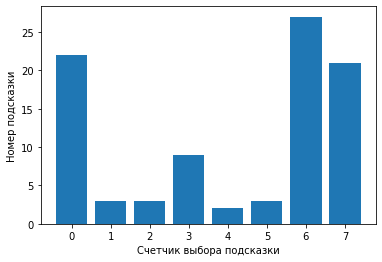

In [36]:
ax=plt.subplot()

ax.bar(dct.keys(), dct.values())

ax.set_xlabel("Счетчик выбора подсказки")
ax.set_ylabel("Номер подсказки")

plt.show()


# С какой частотой решаются конкрентные задачки?
Являются ли какие-то задачки простыми для модели?

In [38]:
mini_lst = list(itertools.product(["mini"], ["standard"], ["sample", "top-k", "top-p"], [1,2]))
vector = []

for model_size, realization, gen_regime, seed in mini_lst:
    vector += [compute_accuracy(dataset_processer, output_processer, model_size, realization, gen_regime, seed, log=False, vector=True)["vector"]]

In [39]:
labels = [[pair[1] for pair in element] for element in vector]


In [40]:
indices = []

for i, cnt in enumerate(np.sum(labels, axis=0)):
    if cnt:
        indices.append(i)
        print("Индекс решенной задачи: {}, сколько раз рещилась задача: {}".format(i, cnt))

Индекс решенной задачи: 6, сколько раз рещилась задача: 1
Индекс решенной задачи: 13, сколько раз рещилась задача: 1
Индекс решенной задачи: 20, сколько раз рещилась задача: 2
Индекс решенной задачи: 29, сколько раз рещилась задача: 2
Индекс решенной задачи: 30, сколько раз рещилась задача: 1
Индекс решенной задачи: 32, сколько раз рещилась задача: 1
Индекс решенной задачи: 41, сколько раз рещилась задача: 1
Индекс решенной задачи: 42, сколько раз рещилась задача: 1
Индекс решенной задачи: 48, сколько раз рещилась задача: 1
Индекс решенной задачи: 96, сколько раз рещилась задача: 2


In [41]:
lens_mas_easy = []
for idx in indices:
    lens_mas_easy.append(len(dataset_processer.dataset[idx]["question"].split()))

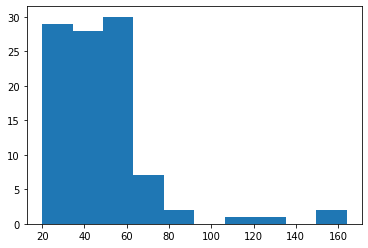

In [42]:
lens_mas = [len(example["question"].split()) for example in dataset_processer.dataset[:100]]
plt.hist(lens_mas)
plt.show()

In [43]:
print("Средняя длина простых задач - {:2.2f}\nСредняя длина всех задач в выборке {:2.2f}".\
  format(np.mean(lens_mas_easy), np.mean(lens_mas) ))

Средняя длина простых задач - 42.50
Средняя длина всех задач в выборке 48.76
